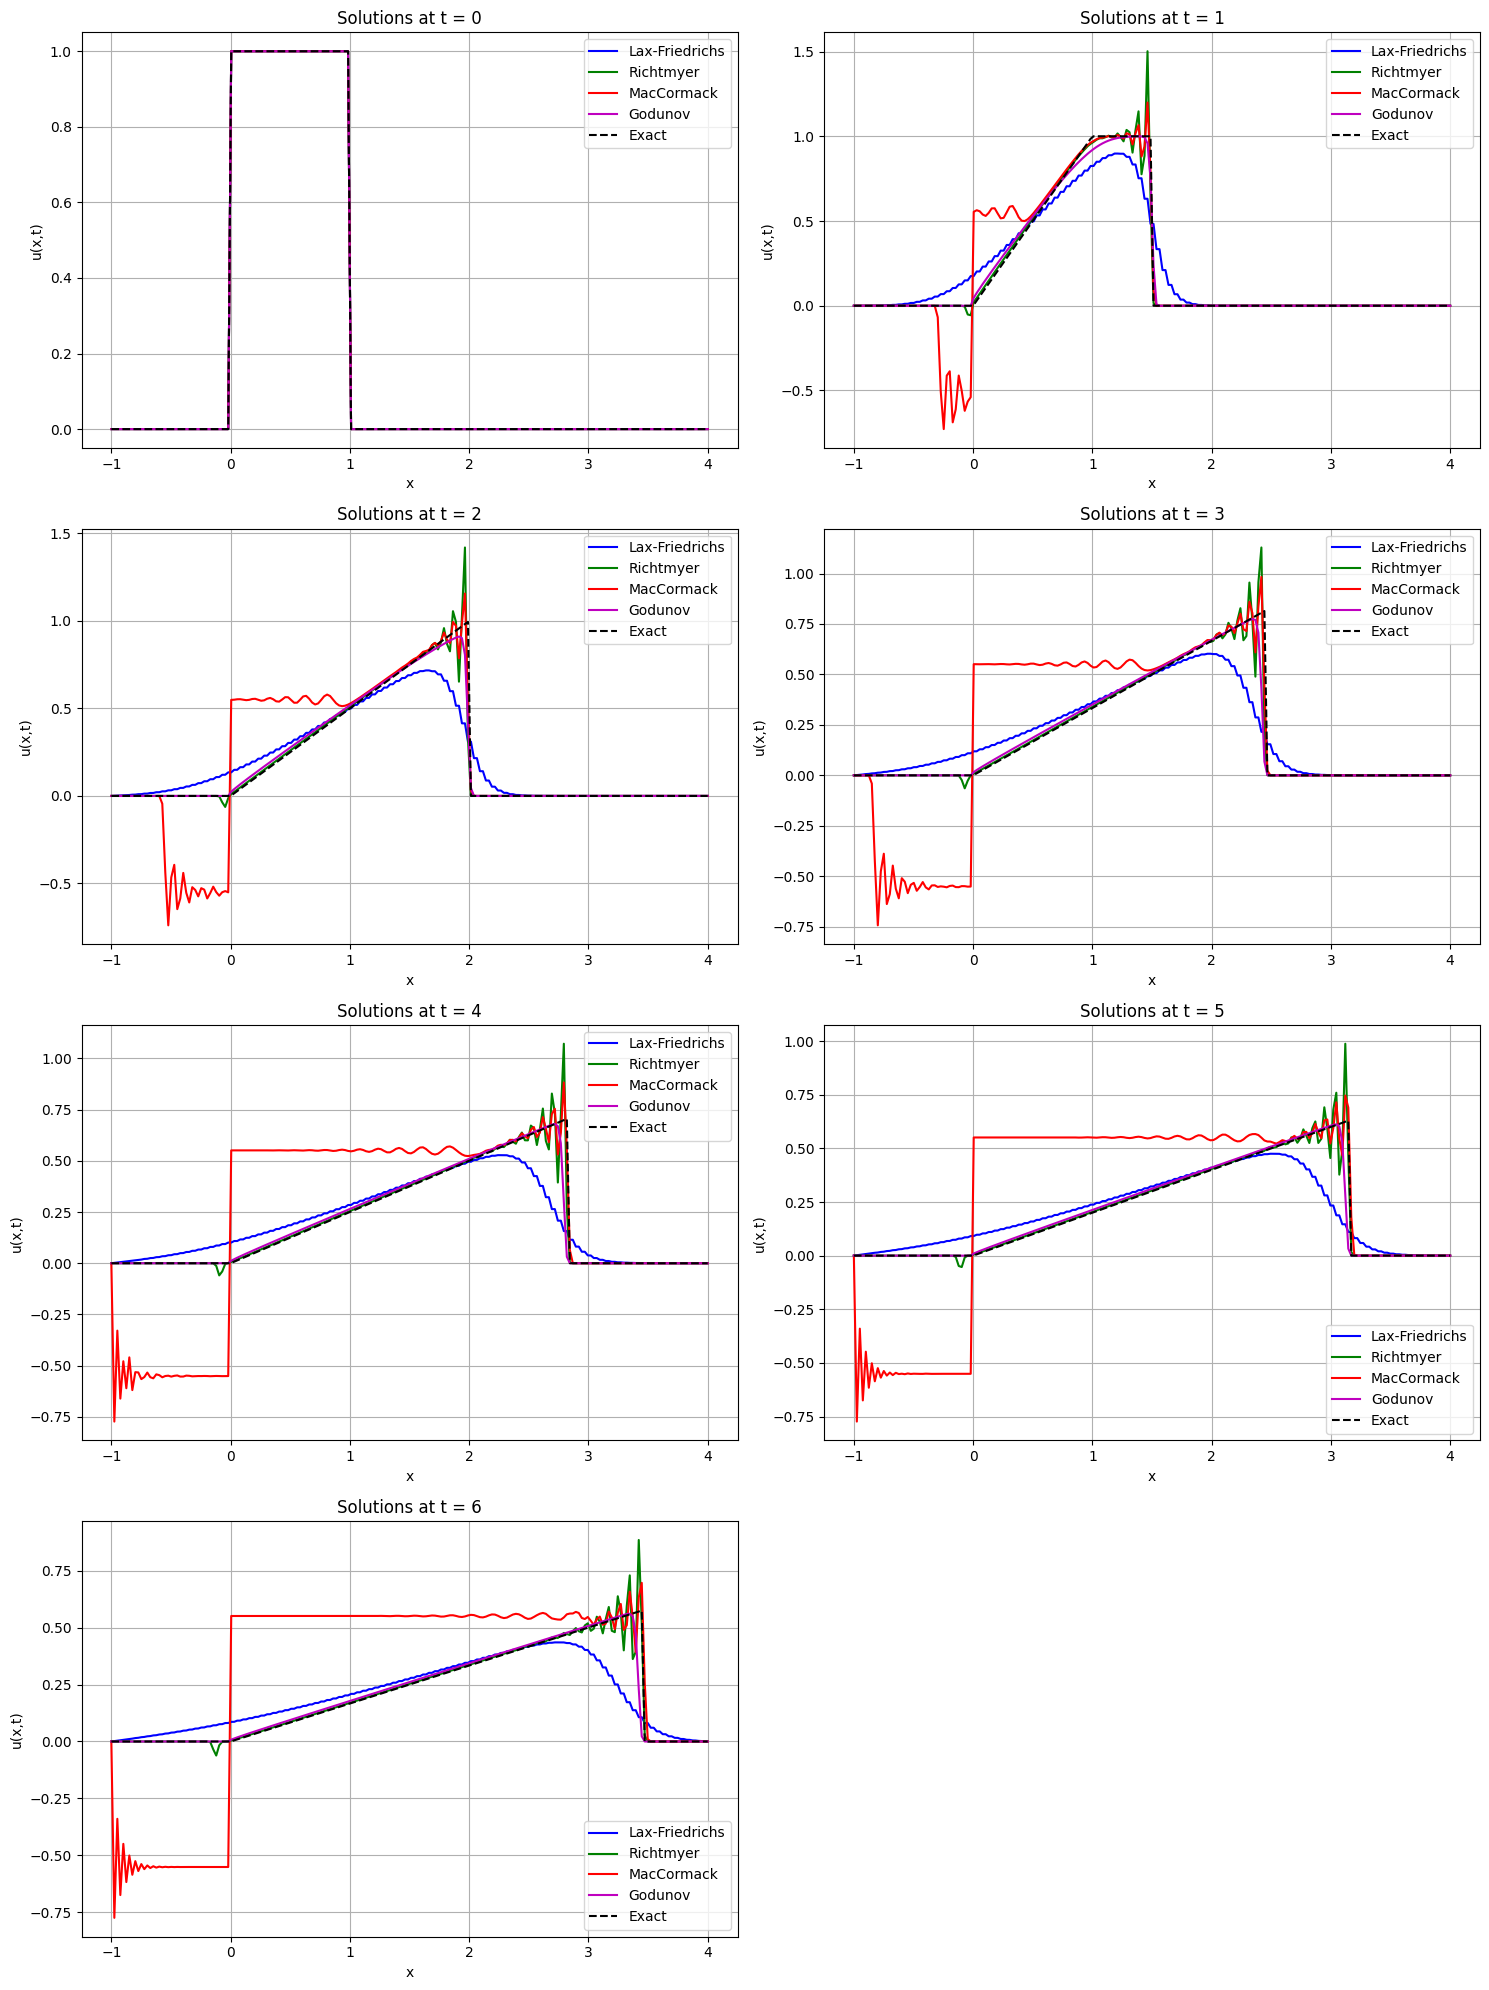

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x_min, x_max = -1, 4
N = 200
x = np.linspace(x_min, x_max, N)
h = x[1] - x[0]

dt = 0.3 * h
t_final = 6
nt = int(t_final / dt) + 1
times = [0, 1, 2, 3, 4, 5, 6]

u0 = np.where((x >= 0) & (x <= 1), 1.0, 0.0)

def flux(u):
    return 0.5 * u**2

def exact_solution(x, t):
    u_exact = np.zeros_like(x)
    if t <= 2:
        for i, xi in enumerate(x):
            if xi < 0:
                u_exact[i] = 0
            elif 0 <= xi <= t:
                u_exact[i] = xi / t
            elif t < xi < 1 + t/2:
                u_exact[i] = 1
            else:
                u_exact[i] = 0
    else:
        for i, xi in enumerate(x):
            if xi < 0:
                u_exact[i] = 0
            elif 0 <= xi <= np.sqrt(2*t):
                u_exact[i] = xi / t
            else:
                u_exact[i] = 0
    return u_exact

solutions_lf = []
solutions_ri = []
solutions_mc = []
solutions_gd = []

u_lf = u0.copy()
u_ri = u0.copy()
u_mc = u0.copy()
u_gd = u0.copy()

solutions_lf.append(u_lf.copy())
solutions_ri.append(u_ri.copy())
solutions_mc.append(u_mc.copy())
solutions_gd.append(u_gd.copy())

def godunov_flux(uL, uR):
    if uL <= uR:
        if uL >= 0:
            return flux(uL)
        elif uR <= 0:
            return flux(uR)
        else:
            return 0
    else:
        if uR >= 0:
            return flux(uL)
        elif uL <= 0:
            return flux(uR)
        else:
            return max(flux(uL), flux(uR))

for n in range(1, nt):
    # --- Lax-Friedrichs ---
    u_new_lf = u_lf.copy()
    u_new_lf[1:-1] = 0.5 * (u_lf[2:] + u_lf[:-2]) - (dt / (2*h)) * (flux(u_lf[2:]) - flux(u_lf[:-2]))
    u_lf = u_new_lf.copy()

    # --- Richtmyer ---
    u_half = 0.5 * (u_ri[1:] + u_ri[:-1]) - (dt / (2*h)) * (flux(u_ri[1:]) - flux(u_ri[:-1]))
    u_new_ri = u_ri.copy()
    u_new_ri[1:-1] = u_ri[1:-1] - (dt / h) * (flux(u_half[1:]) - flux(u_half[:-1]))
    u_ri = u_new_ri.copy()

    # --- MacCormack ---
    u_star = np.zeros_like(u_mc)
    u_star[:-1] = u_mc[:-1] - (dt / h) * (flux(u_mc[1:]) - flux(u_mc[:-1]))
    u_star[-1] = u_mc[-1]
    u_new_mc = u_mc.copy()
    u_new_mc[1:] = 0.5 * (u_mc[1:] + u_star[1:] - (dt / h) * (flux(u_star[1:]) - flux(u_star[:-1])))
    u_mc = u_new_mc.copy()

    # --- Godunov ---
    F = np.array([godunov_flux(u_gd[j], u_gd[j+1]) for j in range(N-1)])
    u_new_gd = u_gd.copy()
    u_new_gd[1:-1] = u_gd[1:-1] - (dt / h) * (F[1:] - F[:-1])
    u_gd = u_new_gd.copy()

    if np.isclose(n*dt, times, atol=dt/2).any():
        solutions_lf.append(u_lf.copy())
        solutions_ri.append(u_ri.copy())
        solutions_mc.append(u_mc.copy())
        solutions_gd.append(u_gd.copy())

methods = [solutions_lf, solutions_ri, solutions_mc, solutions_gd]
labels = ['Lax-Friedrichs', 'Richtmyer', 'MacCormack', 'Godunov']
colors = ['b', 'g', 'r', 'm']

fig, axs = plt.subplots(4, 2, figsize=(15, 20))
axs = axs.flatten()

for t_idx, t_val in enumerate(times):
    ax = axs[t_idx]
    for method, label, color in zip(methods, labels, colors):
        ax.plot(x, method[t_idx], label=label, color=color)
    exact_vals = exact_solution(x, t_val)
    ax.plot(x, exact_vals, 'k--', label='Exact')
    ax.set_title(f'Solutions at t = {t_val}')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x,t)')
    ax.grid(True)
    ax.legend()

if len(axs) > len(times):
    axs[-1].axis('off')

plt.tight_layout()
plt.show()
